<a href="https://colab.research.google.com/github/Smasko7/Poverty-Prediction-Challenge/blob/main/Train_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from scipy import stats
from sklearn import tree
import itertools
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

# Load the necessary dataframes

We load the datasets and the labels that the competition provides. Also, we load the preprocessed data that have been created from the Poverty_EDA_and_Preprocessing.ipynb colab file.

In [5]:
df_original = pd.DataFrame(pd.read_csv("train_hh_features.csv"))
labels_df = pd.DataFrame(pd.read_csv("train_hh_gt.csv"))
df_copy_scaled = pd.DataFrame(pd.read_csv("Preprocessed_train_data.csv"))
actual_rates = pd.read_csv("train_rates_gt.csv")

y = labels_df['cons_ppp17']
X = df_copy_scaled
weights = df_original['weight']
survey_ids = df_original['survey_id']

## Calculate poverty rates from consumption predictions

The following function takes the dataframe with the predicted consumption values for each household and survey as input and calculates the poverty rates. The calculation is done for each survey separately, as it is asked by the competition's problem description.

In [ ]:
def calculate_poverty_rates(df, consumption_col='cons_ppp17', weight_col='weight'):
    """Calculates weighted poverty rates based on predictions in df."""
    thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13,
                  9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99, 27.37]
    results = []

    for survey_id in df['survey_id'].unique():
        survey_data = df[df['survey_id'] == survey_id]
        total_weight = survey_data[weight_col].sum()
        row = {'survey_id': int(survey_id)}

        for t in thresholds:
            # We use the prediction column here for the scorer logic
            is_below = (survey_data[consumption_col] < t).astype(int)
            weighted_poverty_rate = (is_below * survey_data[weight_col]).sum() / total_weight
            row[f'pct_hh_below_{t:.2f}'] = weighted_poverty_rate

        results.append(row)

    return pd.DataFrame(results)

## Check if the calculate_poverty_rates() function outputs the real poverty rates when it is fed with the consumption labels as input

In [ ]:
poverty_distribution_check = calculate_poverty_rates(pd.DataFrame({
    'survey_id': survey_ids.values,
    'cons_ppp17': y,
    'weight': weights.values
}))

if np.allclose(poverty_distribution_check.to_numpy(), actual_rates.to_numpy(), atol=1e-8):
  print("Our calculate_poverty_rates works perfectly; Given the consumption labels, it outputs the poverty rates labels")

poverty_distribution_check


Our calculate_poverty_rates works perfectly; Given the consumption labels, it outputs the poverty rates labels


,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,100000,0.067364,0.118927,0.169905,0.221865,0.271564,0.319585,0.366329,0.419816,0.471454,0.523798,0.574413,0.623091,0.671263,0.721329,0.773303,0.819770,0.865121,0.909075,0.954239
1,200000,0.059326,0.111560,0.159023,0.211754,0.263100,0.311758,0.356914,0.407631,0.463443,0.512931,0.559361,0.609337,0.659291,0.708043,0.760932,0.809045,0.860350,0.906385,0.952805
2,300000,0.049803,0.100381,0.149502,0.200144,0.250192,0.300211,0.349596,0.399930,0.449845,0.499930,0.550082,0.599926,0.650088,0.699617,0.750341,0.800111,0.850081,0.899974,0.949988


## Function that calculates competition metric (90% poverty rates MAPE + 10% consumption MAPE)

The function below calculates the wS-wMAPE metric, which is the official competition metric. This metric is a combination of 2 weighted sums, including the weighted MAPE of poverty rates and consumption values. More information on the project description.
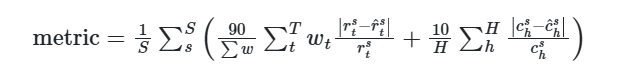

In [ ]:
def competition_metric(y_true, y_pred, weights, survey_ids, actual_poverty_rates=None, metric = 'comp_score'):
    """
    Calculates the 90/10 blended Weighted MAPE used by the competition, if metric = 'comp_score'.
    Calculates the consumption MAPE, if metric = 'consumption_score'.
    Calculates the average weighted poverty rates MAPE, if metric = 'pov_rates_score'.
    """

    # Poverty Rate Weighted MAPE (90%)
    # Calculate predicted rates for these y_pred
    pred_rates_df = calculate_poverty_rates(pd.DataFrame({
        'survey_id': survey_ids.values,
        'cons_ppp17': y_pred,
        'weight': weights.values
    }))


    y_true_df = pd.DataFrame({
        'survey_id': survey_ids.values,
        'y_true': y_true
    })

    y_pred_df = pd.DataFrame({
        'survey_id': survey_ids.values,
        'y_pred': y_pred
    })


    thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13,
                  9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99, 27.37]
    percentile_ranks = np.arange(0.05, 1.0, 0.05) # 5%, 10% ... 95%
    rho_p = 1 - np.abs(percentile_ranks - 0.40)
    rho_p_norm = rho_p / rho_p.sum()

    comp_score_list = []
    cons_list = []
    poverty_rates_list = []

    for s_id in pred_rates_df['survey_id'].unique():
        s_true_rates = actual_poverty_rates[actual_poverty_rates['survey_id'] == s_id].iloc[0, 1:].values
        s_pred_rates = pred_rates_df[pred_rates_df['survey_id'] == s_id].iloc[0, 1:].values

        s_true_cons = y_true_df[y_true_df['survey_id'] == s_id]['y_true']
        s_pred_cons = y_pred_df[y_pred_df['survey_id'] == s_id]['y_pred']



        mape_p = np.abs((s_true_rates - s_pred_rates) / s_true_rates)
        weighted_mape_p = np.sum(mape_p * rho_p_norm)

        mape_cons = mean_absolute_percentage_error(s_true_cons, s_pred_cons)

        survey_score = (90 * weighted_mape_p) + (10 * mape_cons)

        comp_score_list.append(survey_score)
        cons_list.append(10*mape_cons)
        poverty_rates_list.append(100*weighted_mape_p)

    competition_score = np.mean(comp_score_list)
    avg_w_mape_poverty = np.mean(poverty_rates_list)
    mape_cons = np.mean(cons_list)

    # print(f"Competition Metric: {competition_score}")
    # print(f"Weighted Consumption MAPE: {mape_cons:.4f}")
    # print(f"Poverty Rate Weighted: {avg_w_mape_poverty:.4f}")

    if metric == 'pov_rates_score':
        return avg_w_mape_poverty
    elif metric == 'consumption_score':
        return mape_cons
    else:
        return competition_score

## Function of a custom scorer of the competition metric, to evaluate the GridSearch models

In [ ]:
def get_competition_scorer(weights, survey_ids, actual_poverty_rates, metric = 'competition_score'):
    def scorer(estimator, X, y):
        # Inverse log-transform is handled by TransformedTargetRegressor automatically
        y_pred = estimator.predict(X)

        # Align survey_ids and weights with the current validation fold X
        indices = X.index
        s_ids_fold = survey_ids.loc[indices]
        weights_fold = weights.loc[indices]

        return -competition_metric(y, y_pred, weights_fold, s_ids_fold, actual_poverty_rates, metric)
    return scorer

# Linear Grid Search

We first try to train a linear model with ridge regularization, to predict the consumption values. First, the labels are transformed with the log function, because of their exponential (right skewed) distribution. At the end, the inverse function is applied to get the original scale.

We also use the train data's weights as the sample weights, so that the model gives more attention to the households with higher weights. This will, hopefully, result in better poverty rate predictions, as they are calculated based on those train weights.

We apply a grid search with 3 folds. Each fold is a different survey. Thus, in each fit, the model gets trained on the 2 surveys and tries to predict the consumption values and eventually the poverty rates of the 3rd survey. This will help the model generalize better to new, unseen surveys. Also, the mean validation metrics will be more indicative of the expected performance in the test set.

In [ ]:
def run_linear_search(X, y, weights, survey_ids, actual_poverty_rates_df, scorer_metric):

    base_ridge = Ridge(random_state=42)
    model = TransformedTargetRegressor(regressor=base_ridge, func=np.log1p, inverse_func=np.expm1)

    param_grid = {'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 500.0]}
    cv_strategy = GroupKFold(n_splits=3)

    my_scorer = get_competition_scorer(weights, survey_ids, actual_poverty_rates_df, scorer_metric)

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=my_scorer,
        verbose=1,
        n_jobs=1
    )

    print("Beginning Search Optimized for Competition Metric...")
    grid.fit(X, y, groups=survey_ids, sample_weight=weights)

    results_df = pd.DataFrame(grid.cv_results_)

    # Since we used negative scoring (greater_is_better=False), we flip it back to positive
    tracking_report = results_df[[
        'param_regressor__alpha',
        'mean_test_score',
        'std_test_score',
        'rank_test_score'
    ]].copy()

    tracking_report['mean_blended_error'] = -tracking_report['mean_test_score']
    tracking_report = tracking_report.sort_values('rank_test_score')

    print("\n" + "="*50)
    print("DETAILED GRID SEARCH REPORT (Sorted by Performance)")
    print("="*50)
    print(tracking_report.to_string(index=False))
    print("="*50)

    # Save to CSV
    tracking_report.to_csv("linear_grid_search_metrics_log.csv", index=False)
    print("Full metrics log saved to: grid_search_metrics_log.csv")

    print(f"Best Score (Neg) {scorer_metric}: {grid.best_score_:.4f}")
    print(f"Optimal Params: {grid.best_params_}")

    return grid.best_estimator_


scorer_metric = 'comp_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
best_model = run_linear_search(X, y, weights, survey_ids, actual_rates, scorer_metric)

Beginning Search Optimized for Competition Metric...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

DETAILED GRID SEARCH REPORT (Sorted by Performance)
 param_regressor__alpha  mean_test_score  std_test_score  rank_test_score  mean_blended_error
                  500.0       -12.287614        0.413921                1           12.287614
                   10.0       -12.288221        0.414694                2           12.288221
                    1.0       -12.288221        0.414693                3           12.288221
                    0.1       -12.288221        0.414693                4           12.288221
                  100.0       -12.288267        0.413988                5           12.288267
Full metrics log saved to: grid_search_metrics_log.csv
Best Score (Neg) comp_score: -12.2876
Optimal Params: {'regressor__alpha': 500.0}


## Save and show Linear best model's poverty rate predictions on Train Data

In [ ]:
y_pred = best_model.predict(X)

pred_rates_df = calculate_poverty_rates(pd.DataFrame({
    'survey_id': survey_ids.values,
    'cons_ppp17': y_pred,
    'weight': weights.values
}))

pred_rates_df


,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,100000,0.040791,0.086547,0.136533,0.190668,0.240710,0.286366,0.331405,0.383359,0.438998,0.490989,0.547548,0.609333,0.666327,0.725181,0.788989,0.847418,0.898936,0.945904,0.983679
1,200000,0.033793,0.076031,0.124755,0.177041,0.226744,0.274435,0.324813,0.374385,0.428296,0.486242,0.541650,0.598760,0.659166,0.715857,0.782402,0.837588,0.894362,0.944817,0.983880
2,300000,0.028959,0.064728,0.110730,0.163829,0.213002,0.263467,0.312578,0.365568,0.421028,0.479669,0.533419,0.596712,0.657305,0.718717,0.783304,0.841459,0.898089,0.949781,0.984679


## Plot comparison of predictions on Train Data to ground truth

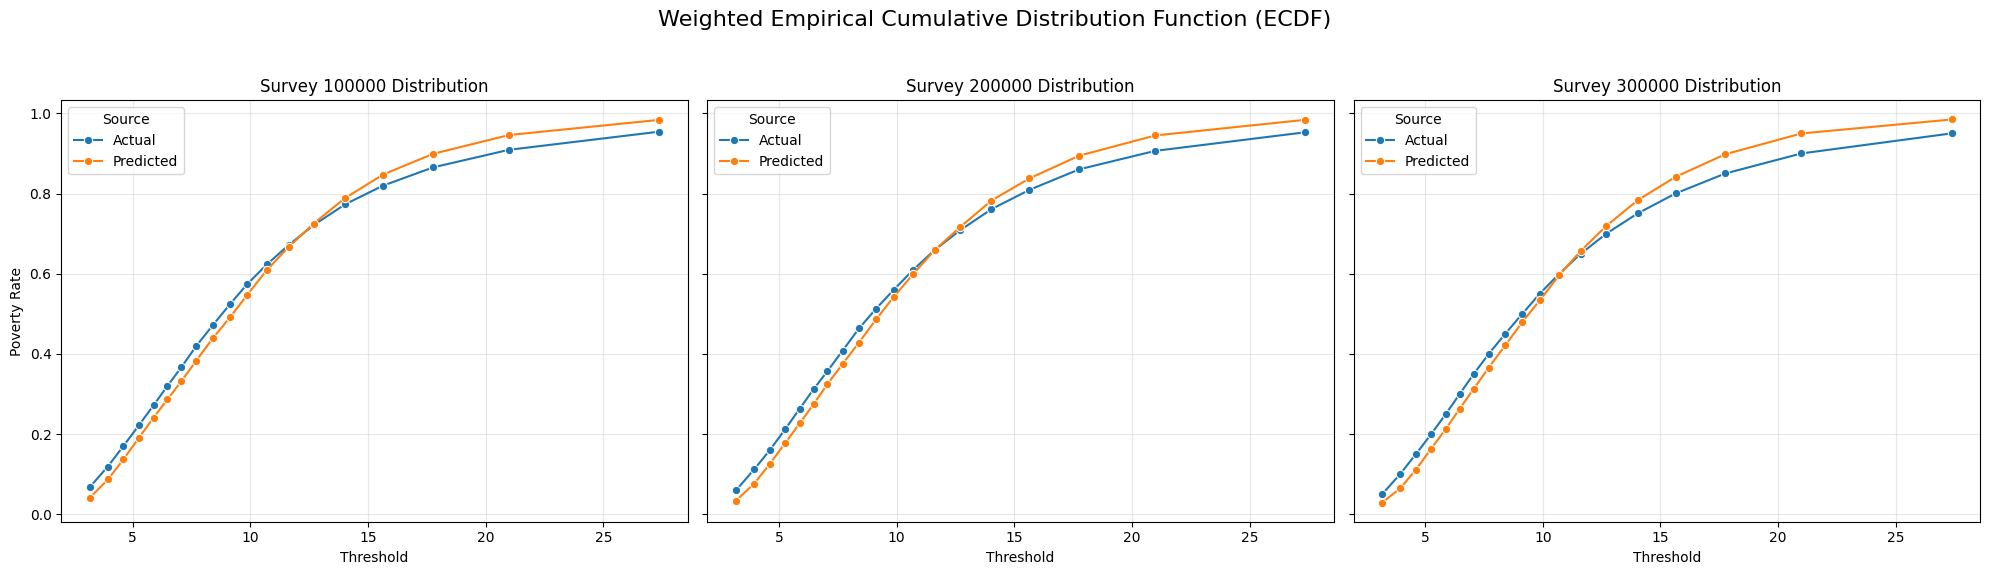

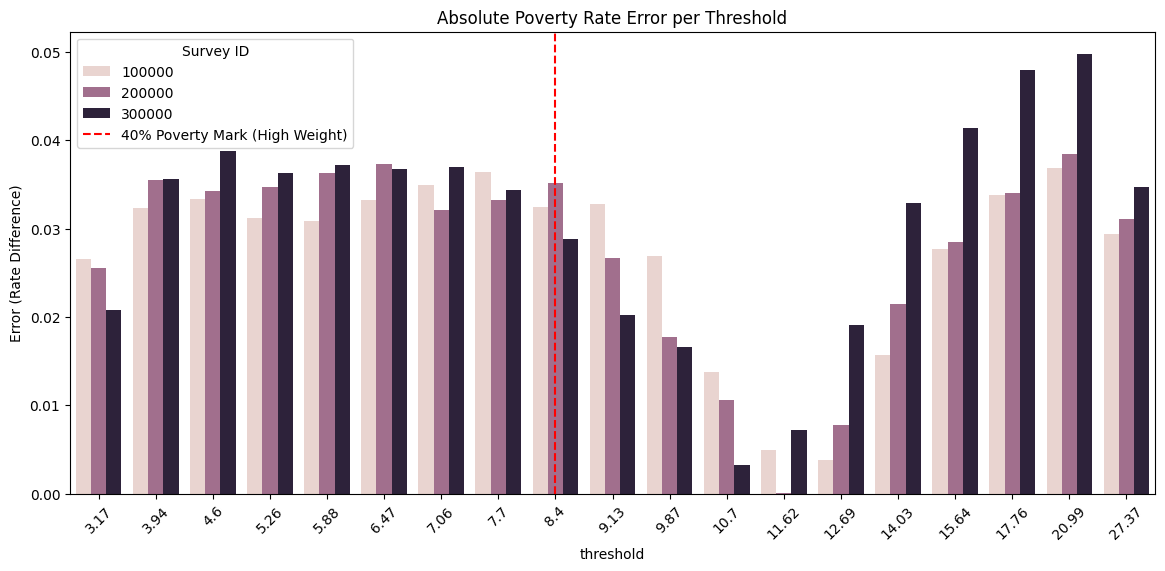

In [ ]:
def plot_poverty_diagnostics(best_model, X, y, weights, survey_ids, actual_rates_df):

    y_pred = best_model.predict(X)

    pred_data = pd.DataFrame({
        'survey_id': survey_ids.values,
        'cons_ppp17': y_pred,
        'weight': weights.values
    })
    pred_rates_df = calculate_poverty_rates(pred_data, consumption_col='cons_ppp17')

    thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13,
                  9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99, 27.37]

    def to_long(df, label):
        melted = df.melt(id_vars=['survey_id'],
                         value_vars=[f'pct_hh_below_{t:.2f}' for t in thresholds],
                         var_name='threshold', value_name='rate')
        melted['threshold'] = melted['threshold'].str.replace('pct_hh_below_', '').astype(float)
        melted['Source'] = label
        return melted

    plot_df = pd.concat([to_long(actual_rates_df, 'Actual'), to_long(pred_rates_df, 'Predicted')])

    # PLOT 1: The ECDF Comparison
    surveys = survey_ids.unique()
    fig, axes = plt.subplots(1, len(surveys), figsize=(20, 6), sharey=True)

    for i, s_id in enumerate(surveys):
        sns.lineplot(data=plot_df[plot_df['survey_id'] == s_id],
                     x='threshold', y='rate', hue='Source', marker='o', ax=axes[i])
        axes[i].set_title(f'Survey {s_id} Distribution')
        axes[i].set_xlabel('Threshold')
        axes[i].set_ylabel('Poverty Rate')
        axes[i].grid(True, alpha=0.3)

    plt.suptitle('Weighted Empirical Cumulative Distribution Function (ECDF)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # PLOT 2: Error Analysis (Weighted MAPE per Threshold)
    # Merge for comparison
    comparison = pd.merge(to_long(actual_rates_df, 'Actual'), to_long(pred_rates_df, 'Predicted'),
                          on=['survey_id', 'threshold'], suffixes=('_true', '_pred'))

    # Calculate Error
    comparison['abs_error'] = np.abs(comparison['rate_true'] - comparison['rate_pred'])

    plt.figure(figsize=(14, 6))
    sns.barplot(data=comparison, x='threshold', y='abs_error', hue='survey_id')
    plt.axvline(x=8, color='red', linestyle='--', label='40% Poverty Mark (High Weight)')
    plt.title('Absolute Poverty Rate Error per Threshold')
    plt.ylabel('Error (Rate Difference)')
    plt.xticks(rotation=45)
    plt.legend(title='Survey ID')
    plt.show()

plot_poverty_diagnostics(best_model, X, y, weights, survey_ids, actual_rates)

As we can observe, the fit is not ideal even in the train data, which indicates high bias and therefore poor predictive power.

# XGBOOST Grid Search

We now try the XGBoost model, with tree_method = 'hist' and number of trees = 100, to decrease the train time.

In [ ]:
from xgboost import XGBRegressor

def run_xgb_search(X, y, weights, survey_ids, actual_poverty_rates_df, scorer_metric):

    base_xgb = XGBRegressor(
        random_state=42,
        tree_method='hist',
        n_estimators=100 # Keep this low for the initial grid search speed
    )

    model = TransformedTargetRegressor(
        regressor=base_xgb,
        func=np.log1p,
        inverse_func=np.expm1
    )

    param_grid = {
        'regressor__max_depth': [7, 9, 11, 13, None],
        'regressor__learning_rate': [0.1, 0.3, 0.5, None],
        'regressor__subsample': [0.5, 0.7, 0.9, None]
    }


    cv_strategy = GroupKFold(n_splits=3)

    my_scorer = get_competition_scorer(weights, survey_ids, actual_poverty_rates_df, scorer_metric)

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=my_scorer,
        verbose=1,
        n_jobs=1
    )

    print("Beginning XGBoost Search Optimized for Competition Metric...")
    grid.fit(X, y, groups=survey_ids, sample_weight=weights)


    # EXTRACT AND PRINT METRICS
    results_df = pd.DataFrame(grid.cv_results_)
    tracking_report = results_df[[
        'params',
        'mean_test_score',
        'std_test_score',
        'rank_test_score'
    ]].copy()

    tracking_report['mean_blended_error'] = -tracking_report['mean_test_score']
    tracking_report = tracking_report.sort_values('rank_test_score')

    print("\n" + "="*50)
    print("DETAILED XGBOOST GRID SEARCH REPORT")
    print("="*50)
    print(tracking_report.to_string(index=False))
    print("="*50)

    tracking_report.to_csv("xgb_grid_search_metrics_log.csv", index=False)

    print(f"Best Score: (Neg) {scorer_metric}: {grid.best_score_:.4f}")
    print(f"Optimal Params: {grid.best_params_}")

    return grid.best_estimator_


scorer_metric = 'comp_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
best_model_xgb3 = run_xgb_search(X, y, weights, survey_ids, actual_rates, scorer_metric)

Beginning XGBoost Search Optimized for Competition Metric...
Fitting 3 folds for each of 80 candidates, totalling 240 fits

DETAILED XGBOOST GRID SEARCH REPORT
                                                                                        params  mean_test_score  std_test_score  rank_test_score  mean_blended_error
     {'regressor__learning_rate': 0.5, 'regressor__max_depth': 9, 'regressor__subsample': 0.5}        -5.656096        1.017400                1            5.656096
     {'regressor__learning_rate': 0.5, 'regressor__max_depth': 7, 'regressor__subsample': 0.5}        -6.260015        1.004865                2            6.260015
    {'regressor__learning_rate': 0.5, 'regressor__max_depth': 11, 'regressor__subsample': 0.5}        -6.279037        0.454604                3            6.279037
    {'regressor__learning_rate': 0.5, 'regressor__max_depth': 13, 'regressor__subsample': 0.7}        -6.696603        1.541491                4            6.696603
     {'regresso

## Save and show XGBOOST best model's poverty rate predictions on Train Data

In [ ]:
y_pred = best_model_xgb3.predict(X)

xgb_pred_rates_df = calculate_poverty_rates(pd.DataFrame({
    'survey_id': survey_ids.values,
    'cons_ppp17': y_pred,
    'weight': weights.values
}))

xgb_pred_rates_df.to_csv('xgb_predicted_poverty_distribution.csv', index=False)
xgb_pred_rates_df

,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,100000,0.055403,0.105768,0.158201,0.214165,0.265892,0.311481,0.361306,0.415084,0.471105,0.524184,0.573545,0.628163,0.676776,0.724934,0.777216,0.827866,0.874369,0.917363,0.959587
1,200000,0.047936,0.099116,0.151378,0.206246,0.260044,0.308985,0.354951,0.407097,0.463219,0.513547,0.562254,0.612845,0.660916,0.712050,0.764552,0.817418,0.863047,0.913071,0.958367
2,300000,0.039722,0.089093,0.140276,0.195719,0.246373,0.296324,0.347067,0.399588,0.449953,0.502210,0.551192,0.606283,0.656771,0.707251,0.758916,0.809017,0.858483,0.908096,0.956400


## Plot comparison of predictions on Train Data to ground truth

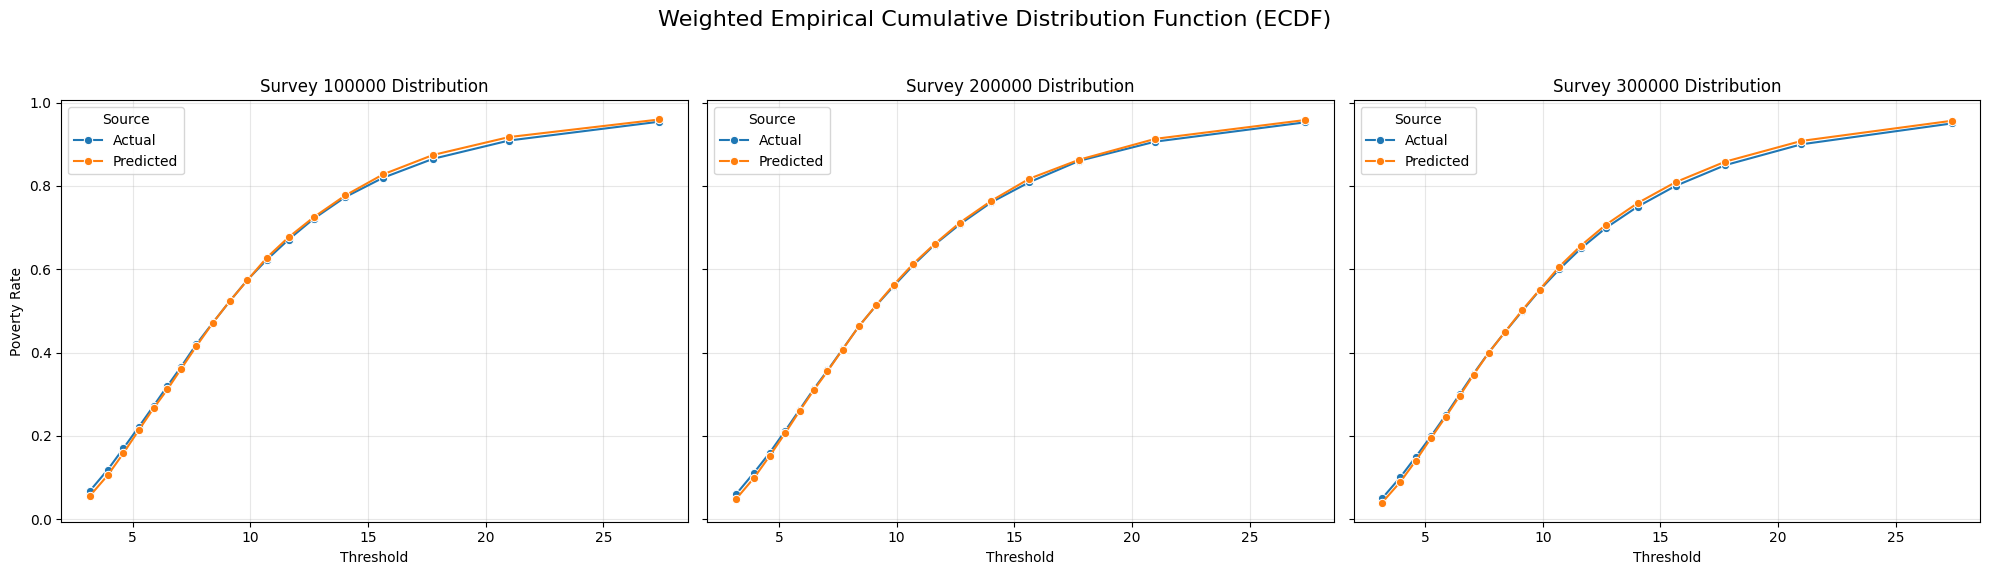

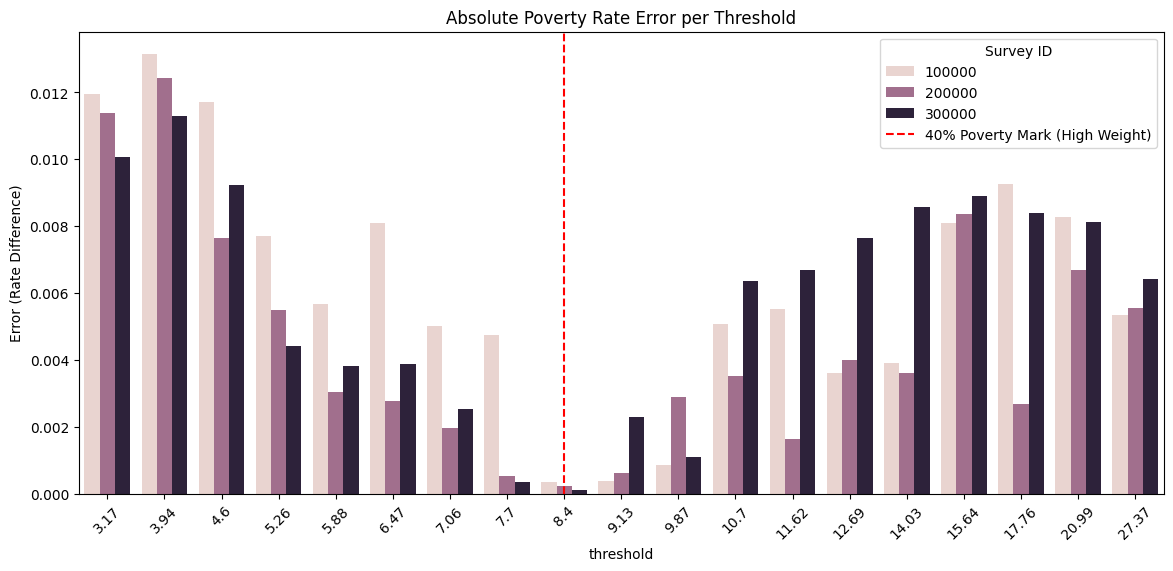

In [ ]:
plot_poverty_diagnostics(best_model_xgb3, X, y, weights, survey_ids, actual_rates)

# Random Forest Grid Search

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def run_rf_search(X, y, weights, survey_ids, actual_poverty_rates_df, scorer_metric):

    base_rf = RandomForestRegressor(
        random_state=42,
        n_jobs=1,
        n_estimators=100
    )

    model = TransformedTargetRegressor(
        regressor=base_rf,
        func=np.log1p,
        inverse_func=np.expm1
    )


    param_grid = {
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_leaf': [1, 2, 4],
        'regressor__max_features': [None, 'sqrt', 'log2']
    }


    cv_strategy = GroupKFold(n_splits=3)

    # scorer_metric = 'comp_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
    my_scorer = get_competition_scorer(weights, survey_ids, actual_poverty_rates_df, scorer_metric)

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=my_scorer,
        verbose=1,
        n_jobs=-1
    )

    print("Beginning Random Forest Search Optimized for 90/10 Blended Metric...")
    grid.fit(X, y, groups=survey_ids, sample_weight=weights)

    results_df = pd.DataFrame(grid.cv_results_)
    tracking_report = results_df[[
        'params',
        'mean_test_score',
        'std_test_score',
        'rank_test_score'
    ]].copy()

    tracking_report['mean_blended_error'] = -tracking_report['mean_test_score']
    tracking_report = tracking_report.sort_values('rank_test_score')

    print("\n" + "="*50)
    print("DETAILED RANDOM FOREST GRID SEARCH REPORT")
    print("="*50)
    print(tracking_report.to_string(index=False))
    print("="*50)

    tracking_report.to_csv("rf_grid_search_metrics_log.csv", index=False)

    print(f"Best Score (Neg) {scorer_metric}: {grid.best_score_:.4f}")
    print(f"Optimal Params: {grid.best_params_}")

    return grid.best_estimator_


scorer_metric = 'comp_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
best_model_rf = run_rf_search(X, y, weights, survey_ids, actual_rates, scorer_metric)

Beginning Random Forest Search Optimized for 90/10 Blended Metric...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

DETAILED RANDOM FOREST GRID SEARCH REPORT
                                                                                             params  mean_test_score  std_test_score  rank_test_score  mean_blended_error
  {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4}       -13.131086        0.705092                1           13.131086
    {'regressor__max_depth': 20, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4}       -13.133650        0.723406                2           13.133650
  {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 2}       -13.192978        0.717114                3           13.192978
    {'regressor__max_depth': 20, 'regressor__max_features': None, 'regressor__min_samples_leaf': 2}       -13.193409        0.740485               

## Save and show Random Forest best model's poverty rate predictions on Train Data

In [ ]:
y_pred = best_model_rf.predict(X)

rf_pred_rates_df = calculate_poverty_rates(pd.DataFrame({
    'survey_id': survey_ids.values,
    'cons_ppp17': y_pred,
    'weight': weights.values
}))

rf_pred_rates_df.to_csv('random_forest_predicted_poverty_distribution.csv', index=False)
rf_pred_rates_df

,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,100000,0.041867,0.092480,0.142999,0.193784,0.242562,0.291153,0.340941,0.395499,0.452458,0.511619,0.566875,0.626725,0.682498,0.739012,0.791327,0.841239,0.886378,0.931044,0.970121
1,200000,0.037264,0.085973,0.133884,0.185821,0.237559,0.285494,0.333772,0.389129,0.445675,0.507611,0.559918,0.617472,0.669999,0.725787,0.780208,0.834667,0.883871,0.928496,0.969319
2,300000,0.028852,0.074565,0.123383,0.175162,0.223323,0.273534,0.323222,0.378855,0.435931,0.493625,0.549560,0.608289,0.665132,0.719740,0.775860,0.829804,0.877699,0.923482,0.968619


## Plot comparison of predictions to ground truth

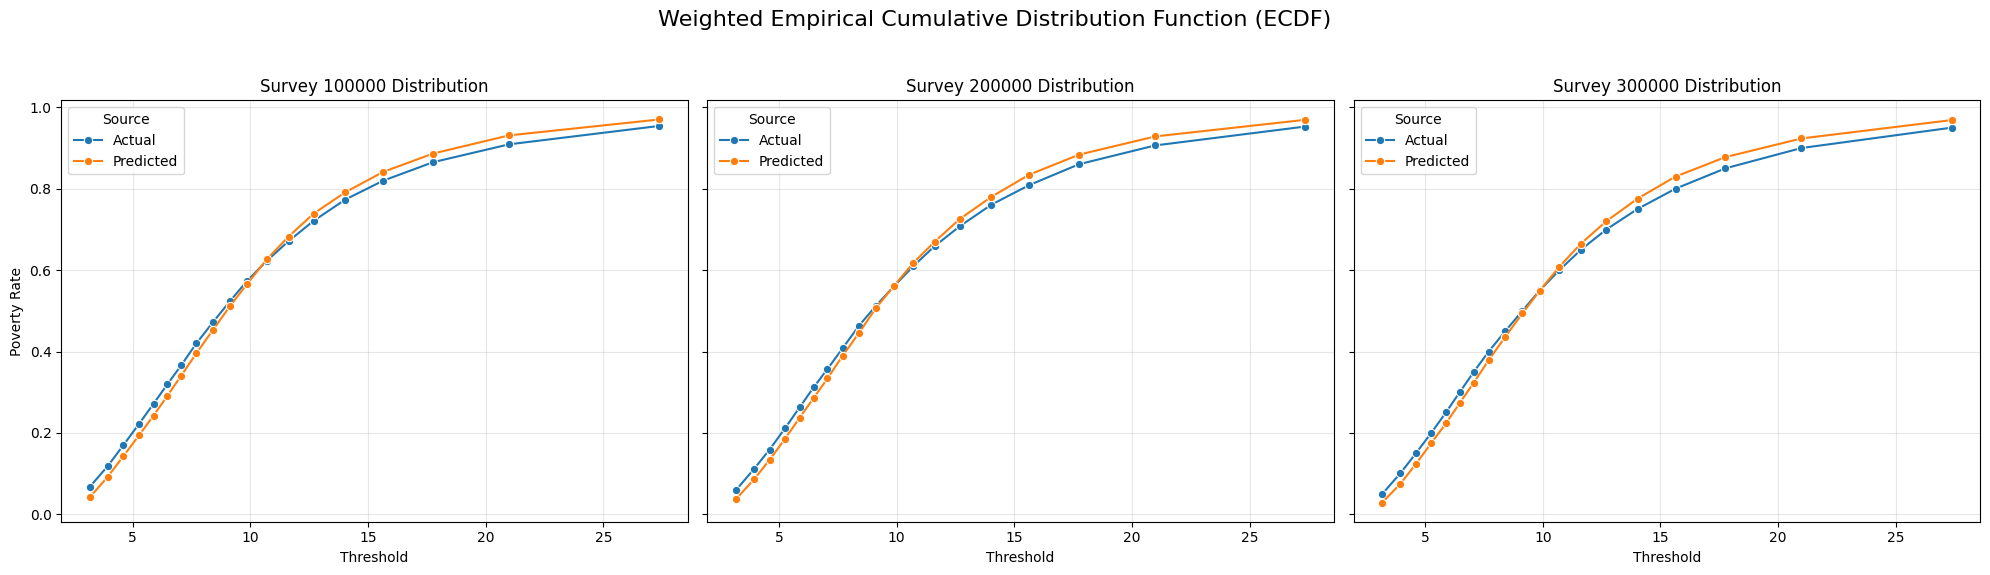

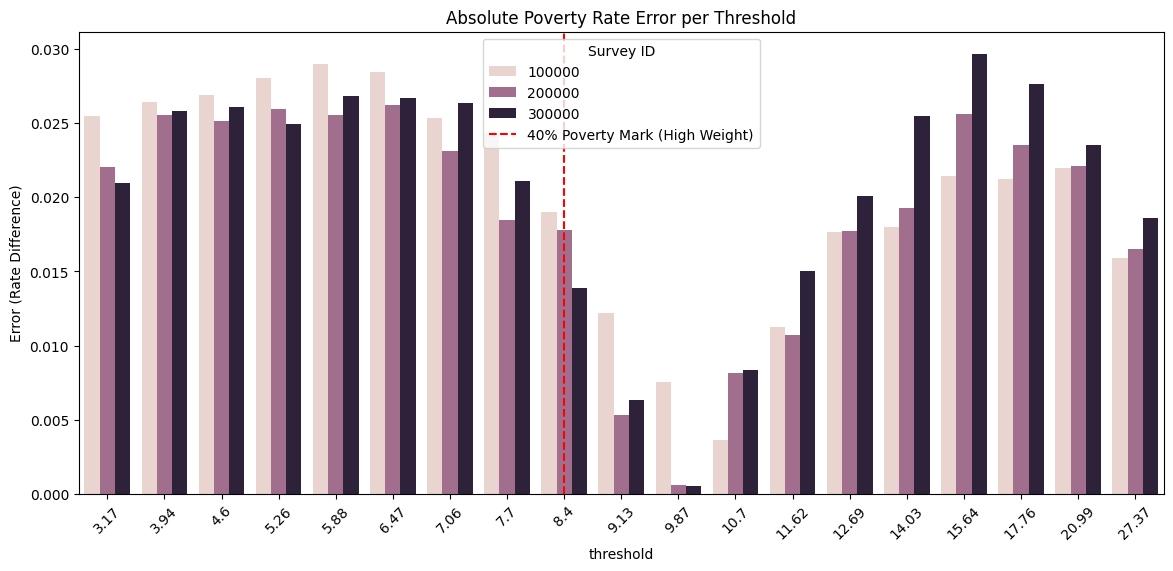

In [ ]:
plot_poverty_diagnostics(best_model_rf, X, y, weights, survey_ids, actual_rates)

# Deep Learning Model (TabNet)

In [ ]:
!pip install pytorch_tabnet

In [ ]:
import torch
import numpy as np
import pandas as pd
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.metrics import Metric
from sklearn.model_selection import GroupKFold

class TabNetCompetitionMetric(Metric):
    def __init__(self):
        self._name = "comp_metric"
        self._maximize = False  # We want to minimize the error

    def __call__(self, y_true, y_score):

        y_true_dollars = np.expm1(y_true.flatten())
        y_pred_dollars = np.expm1(y_score.flatten())

        try:
            scorer_metric = 'comp_score' # 'comp_score', 'consumption_score', 'pov_rates_score'
            score = competition_metric(
                y_true_dollars,
                y_pred_dollars,
                GLOBAL_VAL_WEIGHTS,
                GLOBAL_VAL_SURVEY_IDS,
                GLOBAL_ACTUAL_RATES,
                scorer_metric
            )
            return score
        except Exception as e:
            # Fallback for initialization phase
            return 1.0

def train_tabnet_optimized(X, y, weights, survey_ids, actual_rates):

    y_log = np.log1p(y)

    # Identify Categorical features
    # TabNet needs indices and unique counts
    cat_idxs = []
    cat_dims = []
    for i, col in enumerate(X.columns):
        if col == 'survey_id' or X[col].nunique() < 50: # Heuristic for categories
            X[col] = X[col].astype('category').cat.codes
            cat_idxs.append(i)
            cat_dims.append(X[col].nunique())

    X_values = X.values
    y_values = y_log.values.reshape(-1, 1)

    gkf = GroupKFold(n_splits=3)

    for train_idx, val_idx in gkf.split(X_values, y_values, groups=survey_ids):

        # GLOBAL SETTINGS FOR THE CUSTOM METRIC
        # We store these globally so the TabNet Metric class can see them
        global GLOBAL_VAL_WEIGHTS, GLOBAL_VAL_SURVEY_IDS, GLOBAL_ACTUAL_RATES
        GLOBAL_VAL_WEIGHTS = weights.iloc[val_idx].reset_index(drop=True)
        GLOBAL_VAL_SURVEY_IDS = survey_ids.iloc[val_idx].reset_index(drop=True)
        GLOBAL_ACTUAL_RATES = actual_rates

        model = TabNetRegressor(
            cat_idxs=cat_idxs,
            cat_dims=cat_dims,
            cat_emb_dim=4,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=5e-3),
            scheduler_params={"step_size":10, "gamma":0.9},
            scheduler_fn=torch.optim.lr_scheduler.StepLR,
            mask_type='entmax',
            seed=42
        )

        print("Training TabNet with 90/10 Blended Metric Early Stopping...")
        model.fit(
            X_train=X_values[train_idx],
            y_train=y_values[train_idx],
            eval_set=[(X_values[val_idx], y_values[val_idx])],
            eval_name=['val'],
            eval_metric=[TabNetCompetitionMetric],
            max_epochs=200,
            patience=30,
            batch_size=4096,
            virtual_batch_size=256,
            # Use sample_weights for the internal MSE Loss (10% part)
            weights=weights.iloc[train_idx].values
        )

        return model


best_tabnet = train_tabnet_optimized(X, y, weights, survey_ids, actual_rates)


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Training TabNet with 90/10 Blended Metric Early Stopping...
epoch 0  | loss: 2.56905 | val_comp_metric: 86.17322|  0:00:23s
epoch 1  | loss: 0.72135 | val_comp_metric: 56.16634|  0:00:32s
epoch 2  | loss: 0.34574 | val_comp_metric: 54.14469|  0:00:41s
epoch 3  | loss: 0.24709 | val_comp_metric: 48.14042|  0:00:50s
epoch 4  | loss: 0.2179  | val_comp_metric: 45.15635|  0:00:59s
epoch 5  | loss: 0.20156 | val_comp_metric: 38.86408|  0:01:08s
epoch 6  | loss: 0.18804 | val_comp_metric: 37.85112|  0:01:17s
epoch 7  | loss: 0.17688 | val_comp_metric: 34.58683|  0:01:26s
epoch 8  | loss: 0.16979 | val_comp_metric: 32.68083|  0:01:35s
epoch 9  | loss: 0.16231 | val_comp_metric: 30.92171|  0:01:44s
epoch 10 | loss: 0.15438 | val_comp_metric: 28.73151|  0:01:55s
epoch 11 | loss: 0.14908 | val_comp_metric: 24.40813|  0:02:03s
epoch 12 | loss: 0.14284 | val_comp_metric: 22.91931|  0:02:13s
epoch 13 | loss: 0.14091 | val_comp_metric: 23.82216|  0:02:22s
epoch 14 | loss: 0.13608 | val_comp_metric: 

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


From the above 4 models (linear regression, xgboost, random forest and TabNet) we can easily conclude that xgboost gives the best overall results in terms of the competition metric. Thus, we are going to further explore the xgboost model and its hyperparameters.